# Federated Learning with Pytorch Backend

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, We will walk you through how to use pytorch backend on SecretFlow for federated learning.  

+ We will use the image clasification task as example
+ Use pytorch as backend
+ We will show how to use multi fl strategy
  
If you want to learn more about federated learning, datasets, etc., you can move to [Federated Learning for Image Classification](Federate_Learning_for_Image_Classification.ipynb).
  
**Here we go!**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.7.0b0


/home/beng003/anaconda/envs/sf_1.7/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-04 15:32:53,799	INFO worker.py:1724 -- Started a local Ray instance.


(raylet) [2024-08-04 15:33:53,720 E 1406374 1406374] (raylet) node_manager.cc:3024: 9 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e29064f18de71ff268d9ba58b01a15f7381710706455fddd80584ab8, IP: 10.0.0.4) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.4`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


### Here, let us first introduce some concepts
BaseModule: Similar to the `torch.nn.module`.    
TorchModel: A wrap class include `loss_fn`,`optim_fn`,`model_def`,`metrics`.  
metric_wrapper: Wrap metrics to workers.  
optim_wrapper: Wrap optim_fn to workers.  
FLModel: Federated model, use `backend` to specify which bachend will be use, use `strategy` to spcify which federated strategy will be use.

In [3]:
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

When we define the model, we only need to inherit `BaseModule` instead of `nn.Module`, and the others are consistent with pytorch.

In [4]:
class DNN(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(DNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return F.softmax(x, dim=1)


We can continue to use the loss function and optimizer defined in pytorch, the only difference is that we need to wrap it with the wrapper provided in secretflow.

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.4, bob: 0.6},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

train_data = train_data[0:2]
train_label = train_label[0:2]
test_data = test_data[0:2]
test_label = test_label[0:2]

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
model_def = TorchModel(
    model_fn=DNN,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=2, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=2, average='micro'),
    ],
)

In [6]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [7]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=1,
    batch_size=1,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c2818b7f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c2818bd60>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c2818b550>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c281b8640>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 1, 'batch_sampling_rate': None, 'epochs': 1, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c281b8a00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c281b8790>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c28

RayTaskError(OutOfMemoryError): [36mray::_Masker.mask()[39m (pid=1406953, ip=10.0.0.4, actor_id=df6f7afe3d03e994685ea2b901000000, repr=<secretflow.security.aggregation.secure_aggregator._Masker object at 0x7f1a22bb8340>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 10.0.0.4, ID: e29064f18de71ff268d9ba58b01a15f7381710706455fddd80584ab8) where the task (task ID: ffffffffffffffff00dcf87428834483c6025a4801000000, name=PYUFedAvgW.__init__, pid=1407037, memory used=0.36GB) was running was 14.36GB / 15.11GB (0.950209), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 9ceb8bb7cad65b9f9747b9f4b88b6715935b8dbd7b28ef3553fa6efc) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.0.0.4`. To see the logs of the worker, use `ray logs worker-9ceb8bb7cad65b9f9747b9f4b88b6715935b8dbd7b28ef3553fa6efc*out -ip 10.0.0.4. Top 10 memory users:
PID	MEM(GB)	COMMAND
1406237	2.04	/home/beng003/anaconda/envs/sf_1.7/bin/python -m ipykernel_launcher --f=/home/beng003/.local/share/j...
1380183	0.84	/home/beng003/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/node...
1379809	0.68	/home/beng003/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/node...
1389201	0.37	/home/beng003/anaconda/envs/sf_1.7/bin/python -m ipykernel_launcher --f=/home/beng003/.local/share/j...
1407037	0.36	ray::PYUFedAvgW.__init__
1407036	0.36	ray::PYUFedAvgW.__init__
1406953	0.14	ray::_Masker
1406952	0.14	ray::_Masker
15861	0.07	/home/beng003/anaconda/envs/sf_1.7/lib/python3.10/site-packages/ray/core/src/ray/gcs/gcs_server --lo...
1379748	0.05	/home/beng003/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/node...
Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

2024-08-04 15:35:11,579	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_Masker.mask() (pid=1406953, ip=10.0.0.4, actor_id=df6f7afe3d03e994685ea2b901000000, repr=<secretflow.security.aggregation.secure_aggregator._Masker object at 0x7f1a22bb8340>)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 10.0.0.4, ID: e29064f18de71ff268d9ba58b01a15f7381710706455fddd80584ab8) where the task (task ID: ffffffffffffffff00dcf87428834483c6025a4801000000, name=PYUFedAvgW.__init__, pid=1407037, memory used=0.36GB) was running was 14.36GB / 15.11GB (0.950209), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 9ceb8bb7cad65b9f9747b9f4b88b6715935b8dbd7b28ef3553fa6efc) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -

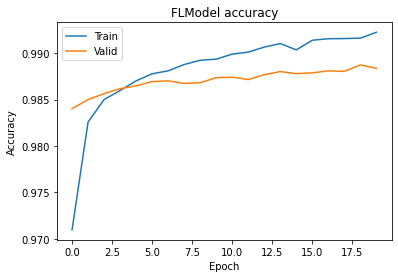

In [8]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()